In [1]:
import random

import gain_loss_asymetry as glasym
import gen_inv_gamma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

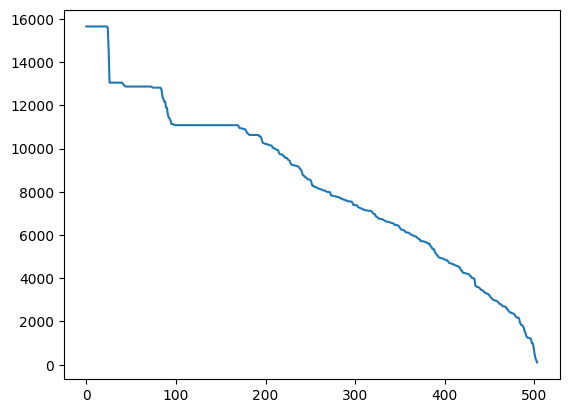

In [4]:
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= 4000].index
stocks = stocks.drop(["SPY"])  # drop the index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-4000]
real_data = real_data.loc[first_date:, stocks]
print(np.sum(np.isnan(real_data), axis=0))
print(f"Shape: {real_data.shape}")
# plt.plot(real_data)
# plt.show()

MMM     0
CVX     0
MO      0
KO      0
AEP     0
       ..
LULU    0
ULTA    0
MSCI    0
PM      0
V       0
Length: 431, dtype: int64
Shape: (4000, 431)


In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_log_price = np.cumsum(np_ret, axis=0)

GenInvGamma fit converged successfully after 105 iterations.
GenInvGamma fit converged successfully after 179 iterations.
Loss likelyhood 0.001832405912735078 with theta : [1.02245261e+01 3.00987779e-01 3.38280909e+00 5.92246166e+02]
Gain likelyhood 0.0014784621942068746 with theta : [ 44.90764668   0.45470768   4.5605405  181.87799041]
std_diff 0.000581929505584451
arg_std_diff 56.547092426187795
diff 0.0020979259748281904
arg diff -46.0


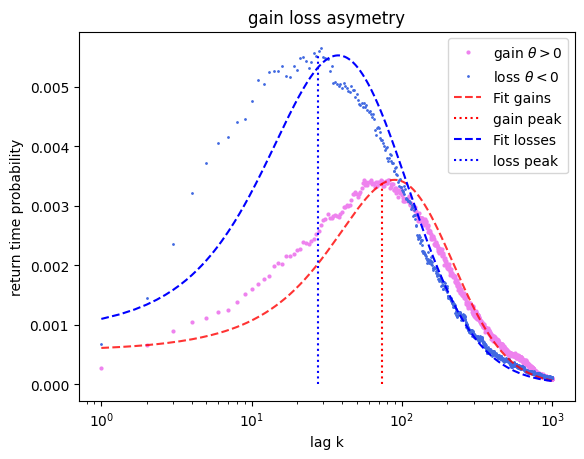

In [9]:
stat = glasym.gain_loss_asymmetry_stat(log_price=np_log_price, max_lag=1000, theta=0.2)
gain, loss = stat["gain"], stat["loss"]
gain_data = np.mean(gain, axis=1)
loss_data = np.mean(loss, axis=1)
theta_gain, log_like_gain = gen_inv_gamma.fit_gen_inv_gamma(
    gain_data, [11.2, 2.4, 0.5, 4.5], method="Newton-CG"
)
theta_loss, log_like_loss = gen_inv_gamma.fit_gen_inv_gamma(
    loss_data, [11.2, 2.4, 0.5, 4.5], method="Newton-CG"
)
x_lin = np.linspace(1, 1000, num=3000)
plt.plot(gain_data, **glasym.gain_plot_setting)
plt.plot(loss_data, **glasym.loss_plot_setting)

max_gain, max_loss, arg_max_gain, arg_max_loss = (
    stat["max_gain"],
    stat["max_loss"],
    stat["arg_max_gain"],
    stat["arg_max_loss"],
)

y_lin = gen_inv_gamma.gen_inf_gamma_pdf(x_lin, theta_gain)
plt.plot(x_lin, y_lin, linestyle="--", alpha=0.8, color="red", label="Fit gains")
plt.plot(
    [arg_max_gain, arg_max_gain],
    [0, max_gain],
    color="red",
    linestyle=":",
    label="gain peak",
)
y_lin = gen_inv_gamma.gen_inf_gamma_pdf(x_lin, theta_loss)
plt.plot(x_lin, y_lin, linestyle="--", alpha=1, color="blue", label="Fit losses")
plt.plot(
    [arg_max_loss, arg_max_loss],
    [0, max_loss],
    color="blue",
    linestyle=":",
    label="loss peak",
)

print(f"Loss likelyhood {np.exp(-log_like_loss)} with theta : {theta_loss}")
print(f"Gain likelyhood {np.exp(-log_like_gain)} with theta : {theta_gain}")
std_diff, arg_std_diff = stat["std_diff"], stat["std_arg_diff"]
print(f"std_diff {std_diff}")
print(f"arg_std_diff {arg_std_diff}")
print(f"diff {max_loss - max_gain}")
print(f"arg diff {arg_max_loss - arg_max_gain}")

plt.gca().set(**glasym.gain_loss_axis_setting)
plt.yscale("linear")
plt.xscale("log")
plt.legend()
plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/gl.png")
plt.show()